<a href="https://colab.research.google.com/github/llA-Wilsonll/Simpsons_Character_Recognition/blob/master/The_Simpsons_Building_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing required packages

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
import re
import itertools
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from sklearn.metrics import classification_report, confusion_matrix

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile 
import os
import random

# Loading the Data Directory
We start off by loading the data (from Google Drive) which has already been prepared (in the The_Simpsons_Organise_Data Notebook) into a directory structure such that we can use the `ImageDataGenerator` method `flow_from_directory`.

In [0]:
# Insert your file ID
# An example : https://drive.google.com/file/d/1iz5JmTB4YcBvO7amj3Sy2_scSeAsN4gd/view?usp=sharing
zip_id = '1Efm6aoutC8kQ36b-sCzewpj1pov4aoMB'

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('/content/simpsons_generator'):
    os.makedirs('/content/simpsons_generator')

# 2. Download Zip
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('simpsons_generator_directory_edit.zip')

# 3. Unzip
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('simpsons_generator_directory_edit.zip', 'r')
zip_ref.extractall('/content/simpsons_generator/')
zip_ref.close()

Uncompressing zip file


## Training Images

In [0]:
base_dir = '/content/simpsons_generator/simpsons_generator_directory_edit/'

In [0]:
characters = os.listdir(base_dir + 'training')

num_images_train = {}
for character in characters:
  num_images = len(os.listdir(base_dir + 'training/' + character))
  num_images_train[character] = num_images
  
# Printing the frequency table
listofTuples = sorted(num_images_train.items(), reverse=True, key=lambda x: x[1])
 
# Iterate over the sorted sequence
print("NUMBER OF TRAINING IMAGES")
for elem in listofTuples :
    print("{0:<26}{1:^2}{2:>13}".format(elem[0],"::", str(elem[1]) + " images."))

NUMBER OF TRAINING IMAGES
homer_simpson             :: 2021 images.
ned_flanders              :: 1308 images.
moe_szyslak               :: 1306 images.
lisa_simpson              :: 1218 images.
bart_simpson              :: 1207 images.
marge_simpson             :: 1161 images.
krusty_the_clown          :: 1085 images.
principal_skinner         :: 1074 images.
charles_montgomery_burns  :: 1073 images.
milhouse_van_houten       ::  996 images.
chief_wiggum              ::  918 images.
abraham_grampa_simpson    ::  852 images.
sideshow_bob              ::  839 images.
apu_nahasapeemapetilon    ::  602 images.


## Validation Images

In [0]:
characters = os.listdir(base_dir + 'validation')

num_images_valid = {}
for character in characters:
  num_images = len(os.listdir(base_dir + 'validation/' + character))
  num_images_valid[character] = num_images
  
# Printing the frequency table
listofTuples = sorted(num_images_valid.items(), reverse=True, key=lambda x: x[1])
 
# Iterate over the sorted sequence
print("NUMBER OF VALIDATION IMAGES")
for elem in listofTuples :
    print("{0:<26}{1:^2}{2:>13}".format(elem[0],"::", str(elem[1]) + " images."))

NUMBER OF VALIDATION IMAGES
homer_simpson             ::  225 images.
ned_flanders              ::  146 images.
moe_szyslak               ::  146 images.
lisa_simpson              ::  136 images.
bart_simpson              ::  135 images.
marge_simpson             ::  130 images.
krusty_the_clown          ::  121 images.
charles_montgomery_burns  ::  120 images.
principal_skinner         ::  120 images.
milhouse_van_houten       ::  115 images.
chief_wiggum              ::  105 images.
abraham_grampa_simpson    ::   96 images.
sideshow_bob              ::   96 images.
apu_nahasapeemapetilon    ::   70 images.


## Test Images

In [0]:
# Getting a list of images in our test directory
images_list = os.listdir(base_dir + 'testing/test_folder')

# Using regex to remove numbers from list of image names
def remove(list): 
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list] 
    return list
  
images_list = remove(images_list)

# Removing subscript from file name so only character name remains
images_list = [character.replace("_.jpg","") for character in images_list]

# Creating a freqency table for each character in our test set
num_images_test = {} 
  
for i in images_list: 
  if i in num_images_test: 
      num_images_test[i] += 1
  else: 
      num_images_test[i] = 1

# Printing the frequency table
listofTuples = sorted(num_images_test.items(), reverse=True,
                      key=lambda x: x[1])
 
print("NUMBER OF TESTING IMAGES")
# Iterate over the sorted sequence
for elem in listofTuples :
    print("{0:<26}{1:^2}{2:>13}".format(elem[0],"::", str(elem[1]) + " images."))

NUMBER OF TESTING IMAGES
krusty_the_clown          ::   50 images.
marge_simpson             ::   50 images.
apu_nahasapeemapetilon    ::   50 images.
moe_szyslak               ::   50 images.
bart_simpson              ::   50 images.
chief_wiggum              ::   50 images.
homer_simpson             ::   50 images.
lisa_simpson              ::   50 images.
principal_skinner         ::   50 images.
milhouse_van_houten       ::   49 images.
ned_flanders              ::   49 images.
abraham_grampa_simpson    ::   48 images.
charles_montgomery_burns  ::   48 images.
sideshow_bob              ::   47 images.


# Baseline Model
## Defining the Model
We will start off with a simple model whose accuracy will act as a baseline target for which we will try to improve upon (assuming the baseline isn't already good).

In [0]:
# Getting the number of classes (characters) we are training on
num_characters = len(os.listdir(base_dir + 'training'))
print("We have", num_characters, "characters.")

# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_characters, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])

We have 14 characters.


Using the `flow_from_directory` method from `ImageDataGenerator` to point to our training and validation data.

In [0]:
TRAINING_DIR = base_dir + 'training/'
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(64, 64))

VALIDATION_DIR = base_dir + 'validation/'
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='categorical',
                                                              target_size=(64, 64))

Found 15660 images belonging to 14 classes.
Found 1761 images belonging to 14 classes.


## Training the Model

In [0]:
history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/15
157/157 [==============================] - 53s 336ms/step - loss: 1.9426 - acc: 0.3720 - val_loss: 1.4457 - val_acc: 0.5309
Epoch 2/15
157/157 [==============================] - 49s 309ms/step - loss: 1.1946 - acc: 0.6352 - val_loss: 1.0236 - val_acc: 0.6826
Epoch 3/15
157/157 [==============================] - 48s 307ms/step - loss: 0.8551 - acc: 0.7337 - val_loss: 0.8613 - val_acc: 0.7325
Epoch 4/15
157/157 [==============================] - 48s 307ms/step - loss: 0.6324 - acc: 0.8068 - val_loss: 0.7192 - val_acc: 0.7853
Epoch 5/15
157/157 [==============================] - 48s 307ms/step - loss: 0.4562 - acc: 0.8606 - val_loss: 0.6752 - val_acc: 0.7967
Epoch 6/15
157/157 [==============================] - 48s 307ms/step - loss: 0.3177 - acc: 0.9049 - val_loss: 0.6427 - val_acc: 0.8154
Epoch 7/15
157/157 [==============================] - 48s 304ms/step - loss: 0.2050 - acc: 0.9386 - val_loss: 0.6479 - val_acc: 0.8268
Epoch 8/15
157/157 [==============================] - 4

Plotting the Loss and Accuracy:

Text(0.5, 1.0, 'Training and validation loss')

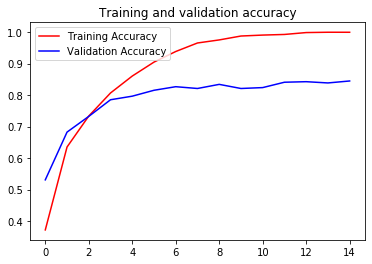

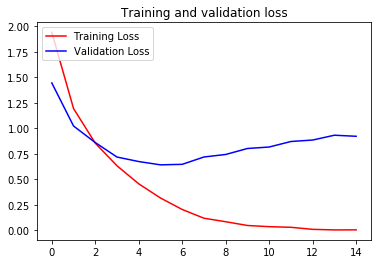

In [0]:
%matplotlib inline

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.legend(loc='upper left')


plt.title('Training and validation loss')

It is clear that our model is overfitting. It is achieving an accuracy of 99.97% on the training set and only 84.5% on the validation set.

## Saving the Model
So that we don't have to retrain the model eveytime we want to run this workbook, I will save the model to a h5 file, and store it in Google Drive.

In [0]:
# Saving the model locally
model.save('/content/simpsons_baseline_model.h5')

Saving this h5 file into Google Drive.

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Saving to GoogleDrive
file1 = drive.CreateFile()
file1.SetContentFile('simpsons_baseline_model.h5')
file1.Upload()

### Loading the Model from Google Drive
After I train the model the first time and save it, in all future sessions I want to use this model I can skip the model defining, training and saving steps and start from here.  

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# 2. Download h5 file
h5_id = '1q7dKR7dkusAJlIfa4RRxEzlLjnbIJzZ3'
print ("Downloading h5 file")
myzip = drive.CreateFile({'id': h5_id})
myzip.GetContentFile('simpsons_baseline_model.h5')

In [0]:
model_load = tf.keras.models.load_model('/content/simpsons_baseline_model.h5')

# Show the model architecture
model_load.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
c

## Evaluating the Model

We now want to get a better sense of how our final model is performing on the validation data set.

Below we define a new generator on our validation set because we want to grab all images from our validation set exactly once and so we set the batch_size to 1.

In [0]:
validation_test_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_test_generator = validation_test_datagen.flow_from_directory(
    directory = base_dir + 'validation/',
    target_size=(64, 64),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 1761 images belonging to 14 classes.


Seeing how well our model performs with the validation set as its input.

In [0]:
test = model_load.evaluate_generator(generator=validation_test_generator,
                        steps=len(validation_test_generator))

In [0]:
# print(model.metrics_names)
print("The Validation Loss is:", test[1])

The Validation Loss is: 0.84497446


We want to take the evaluation further and analyse how well the model performed for each of the different character classes.

We run the below code to get a sense of what information on the classess we can get from the `validation_test_generator`.

In [0]:
# See what classes we have
print(validation_test_generator.classes) 

# See how many validation images we have
print(len(validation_test_generator.classes))

# See what class index corresponds to which character
print(validation_test_generator.class_indices) 

[ 0  0  0 ... 13 13 13]
1761
{'abraham_grampa_simpson': 0, 'apu_nahasapeemapetilon': 1, 'bart_simpson': 2, 'charles_montgomery_burns': 3, 'chief_wiggum': 4, 'homer_simpson': 5, 'krusty_the_clown': 6, 'lisa_simpson': 7, 'marge_simpson': 8, 'milhouse_van_houten': 9, 'moe_szyslak': 10, 'ned_flanders': 11, 'principal_skinner': 12, 'sideshow_bob': 13}


In [0]:
target_names = validation_test_generator.class_indices

# Using our model to make predictions on the validation_test_generator
Y_pred = model_load.predict_generator(generator=validation_test_generator, 
                                      steps=len(validation_test_generator))

# Returning the class with the highest prediction chance
y_pred = np.argmax(Y_pred, axis=1)

### Classification Report

In [0]:
print('Classification Report')
print(classification_report(validation_test_generator.classes, y_pred, target_names=target_names))

Classification Report
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.89      0.74      0.81        96
  apu_nahasapeemapetilon       0.86      0.89      0.87        70
            bart_simpson       0.74      0.71      0.73       135
charles_montgomery_burns       0.78      0.73      0.76       120
            chief_wiggum       0.90      0.90      0.90       105
           homer_simpson       0.85      0.83      0.84       225
        krusty_the_clown       0.86      0.90      0.88       121
            lisa_simpson       0.77      0.74      0.75       136
           marge_simpson       0.89      0.93      0.91       130
     milhouse_van_houten       0.88      0.92      0.90       115
             moe_szyslak       0.78      0.88      0.83       146
            ned_flanders       0.89      0.90      0.89       146
       principal_skinner       0.89      0.88      0.88       120
            sideshow_bob       0.90      0.92      0.

### Confusion Matrix

Confusion Matrix


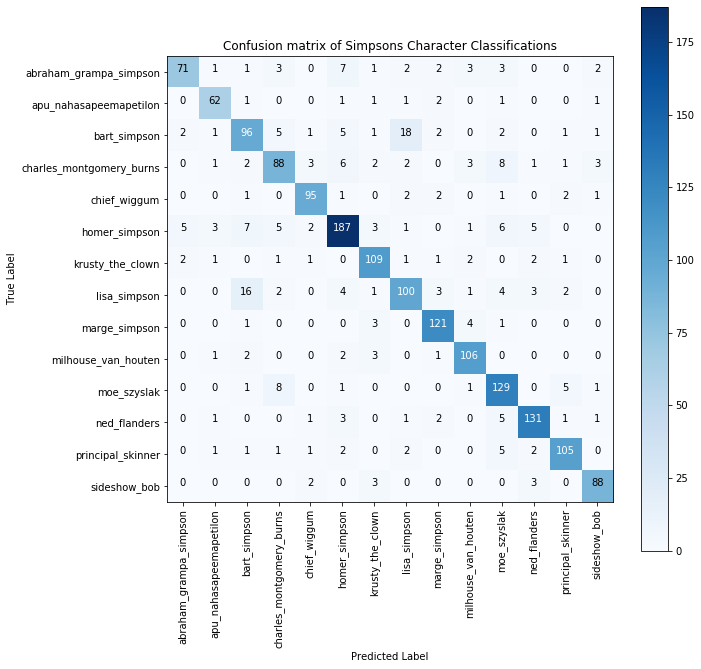

In [0]:
print('Confusion Matrix')
# Creating the confusion matrix as a Numpy array
conf_mtrx = confusion_matrix(validation_test_generator.classes, y_pred)

# Creating a Figure to plot the confusion matirx
fig = plt.figure(figsize = (10,10))
plt.imshow(conf_mtrx, interpolation='none', cmap=plt.cm.Blues)

# Title
plt.title('Confusion matrix of Simpsons Character Classifications')

# Adding a colour bar
plt.colorbar()

# Adding the character names to the X and Y axes
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=90)
plt.yticks(tick_marks, target_names)

# Adding labels to the X and Y axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Displaying the values for each entry in the confusion matrix
thresh = conf_mtrx.max() / 2.
for i, j in itertools.product(range(conf_mtrx.shape[0]), range(conf_mtrx.shape[1])):
    plt.text(j, i, conf_mtrx[i, j],
             horizontalalignment="center",
             color="white" if conf_mtrx[i, j] > thresh else "black")
    
# Running imshow again because the top and bottom of the plot seem to be
# getting cut off when this isnt run
plt.imshow(conf_mtrx, interpolation='none', cmap=plt.cm.Blues)

From the above confusion matrix, we can see that the model is mixing up its predictions of Bart and Lisa, which does make sense as the both have the same skin and shirt colour, and both have spikey hair. Some other character combinations that the model seems to be getting wrong include Moe - Mr. Burns, Homer - Bart and Homer and Grandpa.

# Treatments for Overfitting

There are a few common methods used to reduce overfitting. 

The first and most obvious one is to **add more data**. Given that the our data in this case is images of simpsons characters, it isn't too hard for us to source more images through a simple google images search.

Another way to reduce overfitting is through **data augmentation**. Through actions such as randomly flipping or zooming in on an image, we can increase the amount of images our model is trained on and thus hopefully help to generalise.

If the two above methods still fail to reduce overfitting of our model, we can employ some **regularization techniques** such as dropout or l1/l2 regularization.

## Downloading More data

We will use the same package we used in our *The_Simpsons_Organise_Data* notebook to download some more images of Bart and Lisa.

In [0]:
pip install google_images_download

     |████████████████████████████████| 911kB 5.1MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=f147553bd3c64809972be40e70d2916d4e3c1725976f21a9790161c5d1dc06cd
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [0]:
from google_images_download import google_images_download   #importing the library

In [0]:
response = google_images_download.googleimagesdownload()   #class instantiation

characters = ['bart_simpson', 'lisa_simpson']

for character in characters:
  character_split = character.replace("_"," ")

  arguments_content = {"keywords": character_split,
                       "limit": 100,
                       "output_directory":"/content/simpsons_generator/simpsons_generator_directory_edit/training",
                       "image_directory":character,
                       "format":"jpg"}   #creating dict of arguments
  paths = response.download(arguments_content)   #passing the arguments to the function


Item no.: 1 --> Item name = bart simpson
Evaluating...
Starting Download...


Unfortunately all 100 could not be downloaded because some images were not downloadable. 0 is all we got for this search filter!

Errors: 0


Item no.: 1 --> Item name = lisa simpson
Evaluating...
Starting Download...


Unfortunately all 100 could not be downloaded because some images were not downloadable. 0 is all we got for this search filter!

Errors: 0



Saving to Google Drive

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
zipname = 'simpsons_generator_directory_v2'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/simpsons_generator/simpsons_generator_directory_edit')

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()

Once the zipped file was saved in Google Drive, I downloaded it locally so I could check on the images we just downloaded for Bart and Lisa. After removing many images that weren't appropriate (e.g. of the wrong character, too many characters in the image, image of a collectable/figurine etc.) I zipped the folder and loaded it back into Google Drive.

The below code will load this folder from Google Drive.

In [0]:
# Insert your file ID
# An example : https://drive.google.com/file/d/1iz5JmTB4YcBvO7amj3Sy2_scSeAsN4gd/view?usp=sharing
zip_id = '1HGcEPmGBYAXIp4TUdiIlYodBdHZswNYB'

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('/content/simpsons_generator_v2'):
    os.makedirs('/content/simpsons_generator_v2')

# 2. Download Zip
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('simpsons_generator_directory_v2.zip')

# 3. Unzip
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('simpsons_generator_directory_v2.zip', 'r')
zip_ref.extractall('/content/simpsons_generator_v2/')
zip_ref.close()

Uncompressing zip file


## Training the Model with Data Augmentation and Callback

In [0]:
base_dir = '/content/simpsons_generator_v2/simpsons_generator_directory_edit/'

To allow us to train our model for longer, but still be able to stop training once our model reaches a certain accuracy we can use a **callback**.

Below we implement a callback class that we will use when training the model which will stop training once our model's accuracy is at the accuracy threshold which we will define.

In [0]:
# Define the accuracy threshold we want to use
ACCURACY_THRESHOLD = 0.99

# Implement the callback class which stops training once accuracy reaches ACCURACY_THRESHOLD
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>ACCURACY_THRESHOLD):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

# Instantiate an object of myCallback class
callbacks = myCallback()

As our model will be trained on a more diverse set of images due to the data augmentation, we will add a layer to the model and increase the input size to (128, 128) in hope that the model will be able to fit this new form of diverse input images well.

In [0]:
# Getting the number of classes (characters) we are training on
num_characters = len(os.listdir(base_dir + 'training'))
print("We have", num_characters, "characters.")

# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model_v2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_characters, activation='softmax')
])

model_v2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])

# Show the model architecture
model_v2.summary()

We have 14 characters.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (Non

The main difference in how we train this model compared to the initial baseline model is through the use of data augmentation techniques in the `train_datagen`.

Using this type of data augmentation ensures that our network sees new variations of our data at each and every epoch when trained.

Basically, once a batch of images is presented to the ImageDataGenerator, it will perform a series of random transformations (based on the parameters you provide) to each image before feeding it through the network when training.

In [0]:
TRAINING_DIR = base_dir + 'training/'
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                  rotation_range = 10,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=[0.9, 1.15])
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(128, 128))

VALIDATION_DIR = base_dir + 'validation/'
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='categorical',
                                                              target_size=(128, 128))

Found 15717 images belonging to 14 classes.
Found 1761 images belonging to 14 classes.


In [0]:
history_v2 = model_v2.fit_generator(train_generator,
                                    epochs=30,
                                    verbose=1,
                                    validation_data=validation_generator,
                                    callbacks=[callbacks])
# Could add arguments
#   steps_per_epoch=8
#   validation_steps=8

Epoch 1/30
158/158 [==============================] - 103s 653ms/step - loss: 1.9127 - acc: 0.3885 - val_loss: 1.3631 - val_acc: 0.5832
Epoch 2/30
158/158 [==============================] - 94s 597ms/step - loss: 1.2402 - acc: 0.6122 - val_loss: 0.9907 - val_acc: 0.6854
Epoch 3/30
158/158 [==============================] - 93s 590ms/step - loss: 0.9251 - acc: 0.7121 - val_loss: 0.7156 - val_acc: 0.7768
Epoch 4/30
158/158 [==============================] - 96s 605ms/step - loss: 0.7098 - acc: 0.7788 - val_loss: 0.5783 - val_acc: 0.8217
Epoch 5/30
158/158 [==============================] - 95s 599ms/step - loss: 0.5749 - acc: 0.8181 - val_loss: 0.5276 - val_acc: 0.8376
Epoch 6/30
158/158 [==============================] - 94s 594ms/step - loss: 0.4991 - acc: 0.8443 - val_loss: 0.4565 - val_acc: 0.8580
Epoch 7/30
158/158 [==============================] - 95s 599ms/step - loss: 0.4258 - acc: 0.8676 - val_loss: 0.4335 - val_acc: 0.8683
Epoch 8/30
158/158 [==============================] - 

Plotting the Loss and Accuracy

Text(0.5, 1.0, 'Training and validation loss')

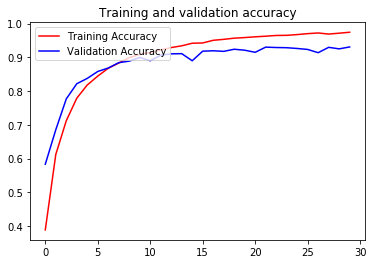

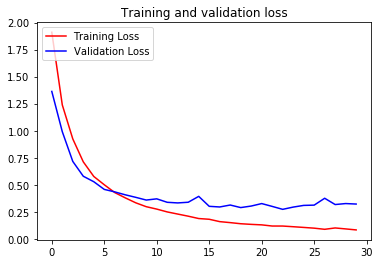

In [0]:
%matplotlib inline

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history_v2.history['acc']
val_acc=history_v2.history['val_acc']
loss=history_v2.history['loss']
val_loss=history_v2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.legend(loc='upper left')


plt.title('Training and validation loss')

### Saving the Model
I will again save this model we have just trained so that we don't have to retrain the model again if we want to use it in a different session.

In [0]:
# Saving the model locally
model_v2.save('/content/simpsons_model_v2.h5')

Saving this h5 file into Google Drive.

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Saving to GoogleDrive
file1 = drive.CreateFile()
file1.SetContentFile('simpsons_model_v2.h5')
file1.Upload()

### Loading the Model from Google Drive 

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

To get the id that we use in the below code, I went to google drive and found the `simpsons_model_v2.h5` file, right clicked it and selected "Get shareable link". The id in the url of that link is what you need for the below code.

In [0]:
# 2. Download h5 file
h5_id = '1Q-ZDsD9WD0qgONyXMjOrz422GMPaFuno'
print ("Downloading h5 file")
myzip = drive.CreateFile({'id': h5_id})
myzip.GetContentFile('simpsons_model_v2.h5')

In [0]:
model_v2_load = tf.keras.models.load_model('/content/simpsons_model_v2.h5')

# Show the model architecture
model_v2_load.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       7

## Evaluating the Model

Just as with the baseline model, we want to get a better sense of how our final model is performing on the validation data set.

In [0]:
validation_test_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_test_generator = validation_test_datagen.flow_from_directory(
    directory = base_dir + 'validation/',
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 1761 images belonging to 14 classes.


Seeing how well our model performs with the validation set as its input.

In [0]:
test_v2 = model_v2_load.evaluate_generator(generator=validation_test_generator,
                                           steps=len(validation_test_generator))

In [0]:
# print(model.metrics_names)
print("The Validation Loss is:", test_v2[1])

The Validation Loss is: 0.93072116


Thus, our model now has an accuracy of **93.1%** on the validation set. This is noticeably better than the 84.5% accuracy on the validation data set that the baseline model had.

In [0]:
target_names = validation_test_generator.class_indices

# Using our model to make predictions on the validation_test_generator
Y_pred = model_v2_load.predict_generator(generator=validation_test_generator, 
                                         steps=len(validation_test_generator))

# Returning the class with the highest prediction chance
y_pred = np.argmax(Y_pred, axis=1)

### Classification Report

In [0]:
print('Classification Report')
print(classification_report(validation_test_generator.classes, y_pred, target_names=target_names))

Classification Report
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.93      0.86      0.90        96
  apu_nahasapeemapetilon       0.98      0.89      0.93        70
            bart_simpson       0.87      0.90      0.89       135
charles_montgomery_burns       0.92      0.91      0.91       120
            chief_wiggum       0.98      0.96      0.97       105
           homer_simpson       0.88      0.94      0.91       225
        krusty_the_clown       0.92      0.96      0.94       121
            lisa_simpson       0.98      0.87      0.92       136
           marge_simpson       1.00      0.92      0.96       130
     milhouse_van_houten       0.89      0.97      0.92       115
             moe_szyslak       0.94      0.92      0.93       146
            ned_flanders       0.94      0.99      0.96       146
       principal_skinner       0.94      0.96      0.95       120
            sideshow_bob       0.95      0.98      0.

### Confusion Matrix

Confusion Matrix


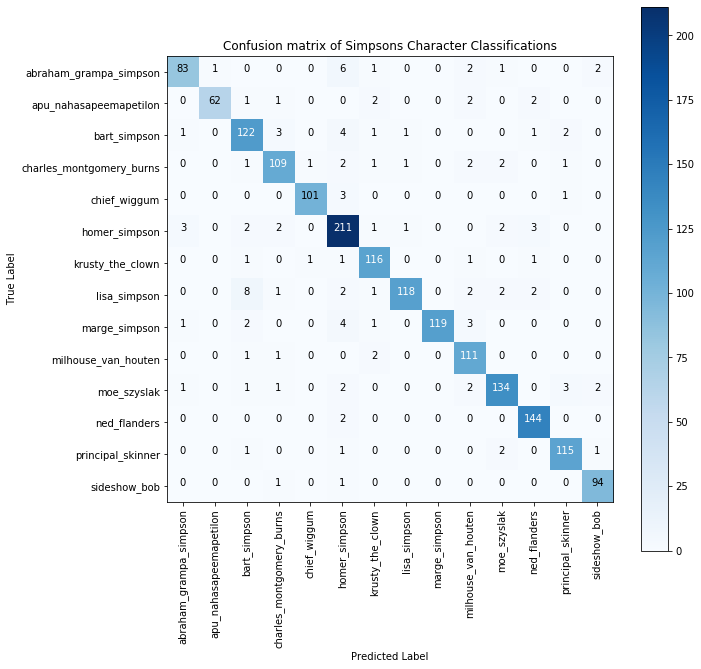

In [0]:
print('Confusion Matrix')
# Creating the confusion matrix as a Numpy array
conf_mtrx = confusion_matrix(validation_test_generator.classes, y_pred)

# Creating a Figure to plot the confusion matirx
fig = plt.figure(figsize = (10,10))
plt.imshow(conf_mtrx, interpolation='none', cmap=plt.cm.Blues)

# Title
plt.title('Confusion matrix of Simpsons Character Classifications')

# Adding a colour bar
plt.colorbar()

# Adding the character names to the X and Y axes
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=90)
plt.yticks(tick_marks, target_names)

# Adding labels to the X and Y axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Displaying the values for each entry in the confusion matrix
thresh = conf_mtrx.max() / 2.
for i, j in itertools.product(range(conf_mtrx.shape[0]), range(conf_mtrx.shape[1])):
    plt.text(j, i, conf_mtrx[i, j],
             horizontalalignment="center",
             color="white" if conf_mtrx[i, j] > thresh else "black")
    
# Running imshow again because the top and bottom of the plot seem to be
# getting cut off when this isnt run
plt.imshow(conf_mtrx, interpolation='none', cmap=plt.cm.Blues)

We can see from the **Classification Report** that the Recall for Grandpa Simpson stands out as being particulalry low at 86%. This lower recall means that in our validation set, there were a decent number of images of Grandpa Simpson which were not classified as Grandpa Simpson when they should have been. We then look to the **Confusion Matrix** and see that 6/13 of these cases which were not predicted as Grandpa Simpson where they should have been were because the model predicted them to be Homer. A contributing factor to this could be the fact that they do have similar features (same "stubble") and as the training set had much more images of homer, the model was biased towards homer and therefore predicted more images to be him.

We can also see in the **Classification Report** that the Precision was lowest for Bart. This means that in our validation set, there were a number of images that where predicted to be Bart which were actually of someone else. If we look to the **Confusion matrix** we can see that 8/18 of these cases were of images that were actually of Lisa, which can be understood due to their physical similarities which we have already mentioned.

### Visualizing Intermediate Representations

Due to the above I decided it would be a good idea to visualise how input images, especially of Grandpa Simpson, are transformed as they go through our model.

The below code is adapted from the *TensorFlow in Practice* specialzation, where I have edited it to display a random image of Grandpa Simpson from our validation set. The code also displays what character our model predicted this to be.

Each row of images in the output is the output of a specific layer. And each image in that row is the result of a specific filter in that output feature map. 

We used the colormap "magma" meaning the more yellow regions are the ones with higher values.

Using image at /content/simpsons_generator_v2/simpsons_generator_directory_edit/validation/abraham_grampa_simpson/pic_0826.jpg

This image is predicted to be of abraham grampa simpson



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


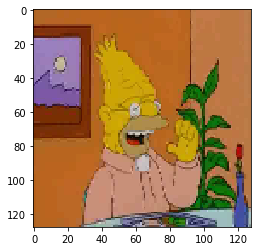

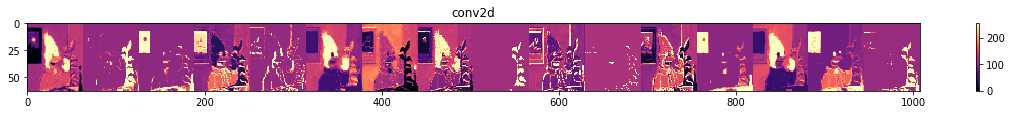

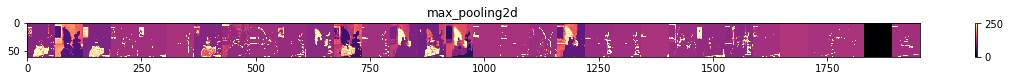

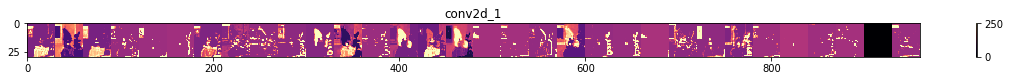

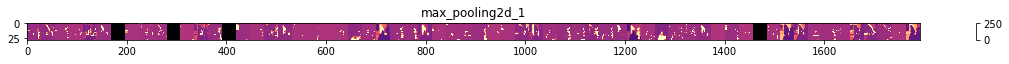

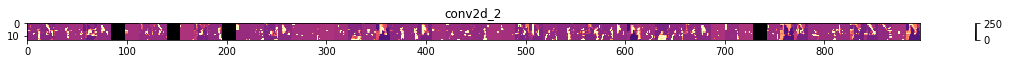

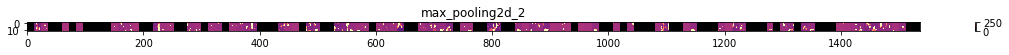

In [0]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model_v2_load.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model_v2_load.input, 
                                            outputs = successive_outputs)

"""
Let's prepare a random input image from the validation set.
As the model performed badly on Grandpa Simpson, we will use a random image of him
"""

val_ags_dir = '/content/simpsons_generator_v2/simpsons_generator_directory_edit/validation/abraham_grampa_simpson'

# Getting the names of the images in abraham_grandpa_simpson validation directory
val_ags_names = os.listdir(val_ags_dir)

# Creating a List of paths to each image
ags_img_files = [os.path.join(val_ags_dir, f) for f in val_ags_names]

# Choosing an image at random
img_path = random.choice(ags_img_files)

print("Using image at", img_path)

# Loading the image
img = load_img(img_path, target_size=(128, 128))  # this is a PIL image

# Showing (printing) the image
plt.imshow(img)

x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# We also want to run the image through our trained model to see what
# it gets classified as
predicted_class = np.argmax(model_v2_load.predict(x), axis=1)
for name, index in validation_test_generator.class_indices.items():
  if index == predicted_class:
    print()
    print("This image is predicted to be of", name.replace("_"," "))
    print()


# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model_v2_load.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='magma')
    plt.colorbar()

**Cleanup Code**

In [0]:
"""
Use this code to delete a directory if required
"""
import shutil

shutil.rmtree('/content/simpsons_generator/testing')